In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

api_key = "Jl22pbuAEAKDhskeyBLk8rIMghbfrjzZ5ENq1P9b0jtp"
crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/ec49ac301b5e4a47abe610ef1f3bbd3a:28866ceb-daf8-40db-9d37-e6cba981926b::"

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=api_key,
    instance=crn,
    name="t3",
    overwrite=True)

C:\Users\kuantum9\anaconda3\envs\hackathon\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
service = QiskitRuntimeService(name="t3")
service.saved_accounts()

{'t3': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'Jl22pbuAEAKDhskeyBLk8rIMghbfrjzZ5ENq1P9b0jtp',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/ec49ac301b5e4a47abe610ef1f3bbd3a:28866ceb-daf8-40db-9d37-e6cba981926b::',
  'verify': True,
  'private_endpoint': False}}

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler


In [5]:
import copy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score
torch.set_default_dtype(torch.float32)
# Read Train Data
datafile = "features_last.csv"
df = pd.read_csv(datafile, sep=',', header=0)
embedding_features = df.to_numpy()

values = [np.fromstring(embedding_features[i][1][1:-1], sep=',', dtype=np.longdouble) for i in range(embedding_features.shape[0])] # a list of numpy arrays
labels = np.array([(np.array(embedding_features[i][0])) for i in range(embedding_features.shape[0])]) # another list of numpy arrays (targets)

embedding_values_other = values[:52]
# Preprocess Train Data
pca = PCA(n_components=4, random_state=42)
X_pca_other = pca.fit_transform(embedding_values_other)
X_pca_other_scaled = MinMaxScaler().fit_transform(X_pca_other)

other_images = X_pca_other_scaled

embedding_values_wanted = values[-5:]
# Preprocess Train Data
pca = PCA(n_components=4, random_state=42)
X_pca_wanted = pca.fit_transform(embedding_values_wanted)
X_pca_wanted_scaled = MinMaxScaler().fit_transform(X_pca_wanted)

wanted_images = X_pca_wanted_scaled

X_pca_values = pca.fit_transform(values)
X_pca_values_scaled = MinMaxScaler().fit_transform(X_pca_values)

In [6]:
labels_bin = []
for i in range(52): labels_bin.append(0)
for i in range(5): labels_bin.append(1)

In [7]:
weights_ep20 = [-1.0044, -0.2340, -0.2958, -0.4287] 
weights_ep5 = [-0.2150,  0.5285,  0.6648,  0.0830]

In [8]:
from qiskit.circuit.library import z_feature_map
num_qubits = len(other_images[0])
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits)
encode = feature_map.assign_parameters(other_images[0])

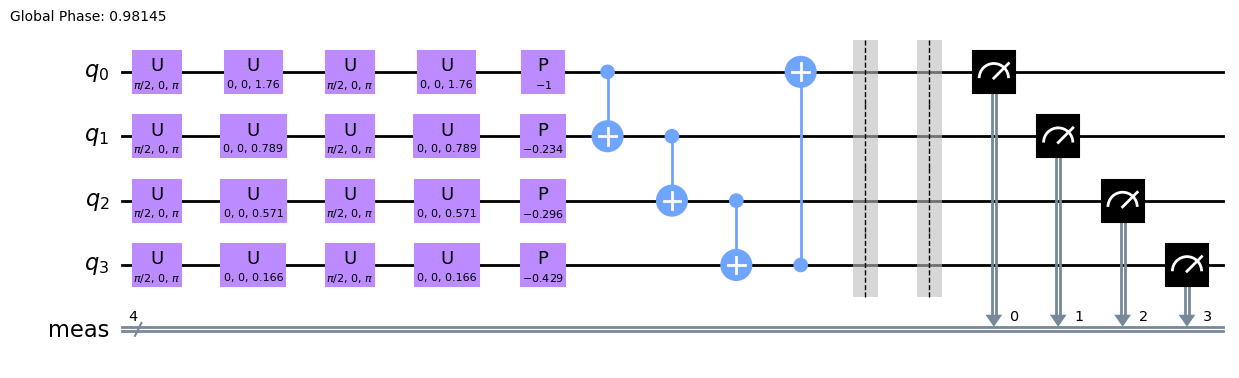

In [9]:
from qiskit.circuit import Parameter, ParameterVector

# Combine the feature map with the ansatz
ansatz_twolocal = QuantumCircuit(num_qubits)
theta_twolocal = weights_ep20

layer_tl = 1
for _ in range(layer_tl):
    for i in range(num_qubits): ansatz_twolocal.rz(theta_twolocal[i], i) 
    for i in range(num_qubits-1): ansatz_twolocal.cx(i, i+1)
    ansatz_twolocal.cx(num_qubits-1, 0)
ansatz_twolocal.barrier()

full_circuit_twolocal = QuantumCircuit(num_qubits)
full_circuit_twolocal.compose(encode, range(num_qubits), inplace=True)
full_circuit_twolocal.compose(ansatz_twolocal, range(num_qubits), inplace=True)

full_circuit_twolocal.measure_all()
# Display the circuit
full_circuit_twolocal.decompose().draw("mpl", style="clifford", fold=-1)

In [10]:
fc4_layer_ep5 = np.array([[-0.2351,  0.0277, -0.2115, -0.0711, -0.2066, -0.3910, -0.4316, -0.1617,
          0.0963,  0.0012,  0.0236, -0.4165, -0.0900, -0.1729,  0.1037,  0.0355],
        [ 0.1231, -0.0076,  0.1109,  0.0188, -0.2576,  0.0043, -0.2967, -0.0235,
         -0.2786, -0.0685, -0.3262,  0.0603,  0.0416, -0.3435, -0.3111, -0.2348],
        [ 0.0642, -0.3777,  0.0699, -0.1888,  0.0367,  0.0018,  0.0989, -0.3670,
          0.0202,  0.0448,  0.0066, -0.2048, -0.1207, -0.2252,  0.0657, -0.1166],
        [ 0.0563, -0.1018, -0.0319, -0.1430, -0.1675, -0.2551, -0.0752, -0.3809,
         -0.0765,  0.1977, -0.4347,  0.1980, -0.3763, -0.3395, -0.1019,  0.1669],
        [-0.1070,  0.0942,  0.0910, -0.0043, -0.1046, -0.1710, -0.1705,  0.0892,
          0.0699, -0.1449,  0.0880, -0.0722, -0.2785, -0.2465,  0.0263, -0.1245],
        [-0.2210,  0.1212,  0.1990, -0.1621, -0.0175,  0.2955,  0.0456, -0.2462,
         -0.1714,  0.1071,  0.1718,  0.0037, -0.0384,  0.2964,  0.0816, -0.1907],
        [ 0.2441,  0.1648, -0.1785,  0.2809,  0.0348,  0.2112,  0.1733, -0.0181,
          0.1370, -0.1837,  0.2539,  0.1631,  0.0968,  0.1121,  0.0168,  0.0119],
        [ 0.0692, -0.0041,  0.2156, -0.0906,  0.0341, -0.2856, -0.1335, -0.2227,
          0.0103, -0.0876, -0.1654, -0.2737,  0.1314,  0.0173,  0.2603,  0.1725]])

In [11]:
fc4_layer_ep20 = np.array([[-0.3106, -0.2433, -0.9537, -0.1273, -1.0876, -0.8525, -0.7825, -0.9599,
         -1.0239, -1.0058, -0.7885, -0.6715, -0.5349, -0.8463, -0.1516, -0.2911],
        [-0.3231, -0.7328, -0.4270, -0.7815, -0.8119, -0.5660, -0.1683, -0.6755,
         -0.7142, -0.5758, -0.7631, -0.4077, -0.8429, -0.5485, -0.7266,  0.0473],
        [-0.5502, -0.6349, -0.6104, -0.9038, -0.7650, -0.7323,  0.2002, -1.0134,
         -0.8102, -0.3693, -1.0151, -0.5393, -0.6926, -0.5769, -0.9971,  0.2874],
        [-0.3213, -0.9089, -0.8316, -0.7984, -0.1076, -0.7469,  0.5311, -0.9848,
         -0.7986,  0.5469, -0.8300,  0.2043, -0.6622, -0.9995, -1.0619, -0.1325],
        [-0.2228, -0.4360, -0.8797, -1.0358, -1.0861, -0.8612,  1.0019, -0.8041,
         -0.2348,  0.0999, -0.7760, -0.1111, -1.0385, -0.8724, -1.1460,  0.3028],
        [-0.3831, -0.1435,  0.7451,  0.8711,  0.7128,  0.8118, -0.4658, -1.1750,
         -0.6001, -1.1239,  0.8536,  0.9766,  0.9540,  0.7455, -0.8076,  0.3177],
        [ 0.0392,  0.9462, -0.8540,  0.7899, -0.8656,  0.5038, -0.5663,  0.9950,
          1.0066, -0.2159,  0.9793, -0.8714,  0.3418, -0.8743,  1.1002, -0.2957],
        [ 0.5005, -1.0329, -1.1972,  0.2608,  0.6391, -1.0167, -1.2608, -0.6534,
         -0.8945,  0.5102,  0.0559, -1.3047, -0.8460,  0.9775, -0.4804, -0.3393]])

In [12]:
from tqdm import tqdm

In [13]:
faces_fake = []
for data in tqdm(X_pca_values_scaled):
    feature_map = z_feature_map(num_qubits)
    encode = feature_map.assign_parameters(data)

    ansatz_twolocal = QuantumCircuit(num_qubits)
    theta_twolocal = weights_ep20
    
    layer_tl = 1
    for _ in range(layer_tl):
        for i in range(num_qubits): ansatz_twolocal.rz(theta_twolocal[i], i) 
        for i in range(num_qubits-1): ansatz_twolocal.cx(i, i+1)
        ansatz_twolocal.cx(num_qubits-1, 0)
    ansatz_twolocal.barrier()
    
    full_circuit_twolocal = QuantumCircuit(num_qubits)
    full_circuit_twolocal.compose(encode, range(num_qubits), inplace=True)
    full_circuit_twolocal.compose(ansatz_twolocal, range(num_qubits), inplace=True)
    
    full_circuit_twolocal.measure_all()
    # Display the circuit
    full_circuit_twolocal.decompose().draw("mpl", style="clifford", fold=-1)

    backend = FakeNairobiV2()
    pm = generate_preset_pass_manager(
        optimization_level=3, backend=backend)
    isa_circ = pm.run(full_circuit_twolocal)
    
    sampler = Sampler(mode=backend)
    job = sampler.run([isa_circ], shots=100000)

    result_sampler = job.result()
    counts_list = result_sampler[0].data.meas.get_counts()
    prob_dist = np.array(list(counts_list.values())) / 100000
    prediction = np.matmul(fc4_layer_ep20, prob_dist)
    predicted = np.argmax(prediction)
    predicted_correct = 7-int(predicted)

    faces_fake.append(predicted_correct)

100%|██████████| 57/57 [00:52<00:00,  1.10it/s]


In [14]:
result_check_fake = [1 if face == 3 else 0 for face in faces_fake]

In [15]:
print(result_check_fake)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

print("Fake Backend")
print(classification_report(labels_bin, result_check_fake))

Fake Backend
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.00      0.00      0.00         5

    accuracy                           0.89        57
   macro avg       0.46      0.49      0.47        57
weighted avg       0.83      0.89      0.86        57



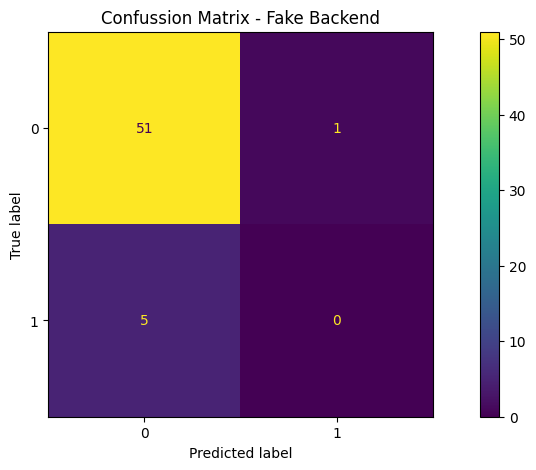

In [17]:
#Confussion Matrix
cm_tr=confusion_matrix(labels_bin, result_check_fake)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
disp_tr.plot(ax=ax)
ax.set_title("Confussion Matrix - Fake Backend")
plt.show()

In [23]:
print("ROC AUC Score Fake: ", roc_auc_score(labels_bin, result_check_fake))

ROC AUC Score Fake:  0.49038461538461536


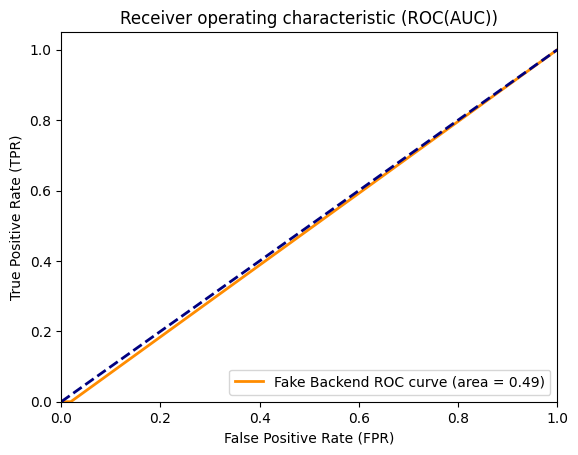

In [18]:
# kurva ROC(AUC)
fpr_tr, tpr_tr, _ = roc_curve(labels_bin, result_check_fake)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2, label=f'Fake Backend ROC curve (area = {roc_auc_tr:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC(AUC))')
plt.legend(loc="lower right")
plt.show()

In [ ]:
faces_hardware = []
for data in tqdm(X_pca_values_scaled):
    feature_map = z_feature_map(num_qubits)
    encode = feature_map.assign_parameters(data)

    ansatz_twolocal = QuantumCircuit(num_qubits)
    theta_twolocal = weights_ep20
    
    layer_tl = 1
    for _ in range(layer_tl):
        for i in range(num_qubits): ansatz_twolocal.rz(theta_twolocal[i], i) 
        for i in range(num_qubits-1): ansatz_twolocal.cx(i, i+1)
        ansatz_twolocal.cx(num_qubits-1, 0)
    ansatz_twolocal.barrier()
    
    full_circuit_twolocal = QuantumCircuit(num_qubits)
    full_circuit_twolocal.compose(encode, range(num_qubits), inplace=True)
    full_circuit_twolocal.compose(ansatz_twolocal, range(num_qubits), inplace=True)
    
    full_circuit_twolocal.measure_all()
    # Display the circuit
    full_circuit_twolocal.decompose().draw("mpl", style="clifford", fold=-1)

    backend = service.least_busy(simulator=False, operational=True, min_num_qubits=num_qubits)
    pm = generate_preset_pass_manager(
        optimization_level=3, backend=backend)
    isa_circ = pm.run(full_circuit_twolocal)
    
    sampler = Sampler(mode=backend)
    job = sampler.run([isa_circ], shots=100000)
    print("job id:", job.job_id())
    result_sampler = job.result()
    counts_list = result_sampler[0].data.meas.get_counts()
    prob_dist = np.array(list(counts_list.values())) / 100000
    prediction = np.matmul(fc4_layer_ep20, prob_dist)
    predicted = np.argmax(prediction)
    predicted_correct = 7-int(predicted)

    faces_hardware.append(predicted_correct)

  0%|          | 0/57 [00:00<?, ?it/s]

job id: d2s3takaumss73e8qnv0


In [ ]:
result_check = [1 if face == 3 else 0 for face in faces]
print(result_check)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import classification_report

print("Real Backend")
print(classification_report(labels_bin, result_check))

In [ ]:
#Confussion Matrix
cm_tr=confusion_matrix(labels_bin, result_check)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
disp_tr.plot(ax=ax)
ax.set_title("Confussion Matrix - Real Backend")
plt.show()

In [ ]:
print("ROC AUC Score Real: ", roc_auc_score(labels_bin, result_check))

In [1]:
# kurva ROC(AUC)
fpr_tr, tpr_tr, _ = roc_curve(labels_bin, result_check)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2, label=f'Real Backend ROC curve (area = {roc_auc_tr:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC(AUC))')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_curve' is not defined